In [1]:
!pip install -U transformers peft bitsandbytes datasets trl evaluate bert_score

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset

ds = load_dataset("squad_v2")
# let's get some stats on the dataset
print(ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


In [4]:
num_training_samples = 15000
num_test_samples = 750
num_validation_samples = 1000
training_samples = ds['train'].select([i for i in range(num_training_samples)])
test_samples = ds['train'].select([i for i in range(num_training_samples, num_training_samples+num_test_samples)])
validation_samples = ds['validation'].select([i for i in range(num_validation_samples)])
print(training_samples)
print(test_samples)
print(validation_samples)


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 15000
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 750
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


In [5]:
from transformers import AutoTokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [6]:
# Define a custom Jinja template for SQuAD v2
custom_template = """
{%- for message in messages %}
    {%- if message['role'] == 'user' %}
        {{- bos_token + '[INST] ' + message['content'].strip() + ' [/INST]' }}
    {%- elif message['role'] == 'system' %}
        {{- '<<SYSTEM>>\\n' + message['content'].strip() + '\\n<</SYSTEM>>\\n\\n' }}
    {%- elif message['role'] == 'assistant' %}
        {{- '[ASST] '  + message['content'].strip() + ' [/ASST]' + eos_token }}
    {%- endif %}
{%- endfor %}
"""

# Assign the template to the tokenizer
tokenizer.chat_template = custom_template

In [7]:

def convert_squad_sample_to_llama_conversation(sample):
    # get the question and context for this sample
    question = sample['question']
    context = sample['context']

    # some questions can have multiple answers, some none at all,
    # for the case of no answers we'll have the model output that the
    # context does not provide an answer, if it has multiple we'll just take
    # the first answer as the ground truth.
    answers = sample['answers']['text']
    if len(answers) == 0 :
      answer = "The context does not provide an answer..."
    else:
      answer = sample['answers']['text'][0]

    # now we define an initial model prompt defining the task and giving the model the context passage
    instruction_prompt_template = '''
    You are a helpful assistant tasked with extracting passages that answer users questions from a given context. Output exact passages word for word that answer the users question. Do not output any other text other than passages in the context passage. Output the minimal amount to answer the question, for example only 2-3 words from the passage. If you cannot find the answer in the context passage output 'The context does not provide an answer...'

    Context: {context}'''

    # now we'll convert these into a list of messages for our conversation
    messages = [
        {"role": "system", "content": instruction_prompt_template.format(context=context)},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]
    # apply the chat template and return the sample
    # we'll also return the single answer we expect and the list of messages without
    # the chat template in case we need them later.
    sample_conversation = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"text": sample_conversation, "messages": messages, "answer": answer}

In [8]:
conversation_training_samples = training_samples.map(convert_squad_sample_to_llama_conversation)
conversation_test_samples = test_samples.map(convert_squad_sample_to_llama_conversation)
conversation_validation_samples = validation_samples.map(convert_squad_sample_to_llama_conversation)

In [9]:
from transformers import AutoTokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [10]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

In [11]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

In [12]:
from peft import LoraConfig
# rank defines the rank of the adapter matrix,
# the higher the rank, the more complex the task it's trying to learn
rank = 128

# the alpha is a scaling factor hyper parameter, basically controls how much our
# adapter will influence the models output, the higher this value
# the more our adapter will overpower the original model weights.
# there is a lot of advice out there for what the alpha value should be
# keeping the alpha at around 2x of what the rank is works for this notebook
alpha = rank*2
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    lora_dropout=0.05, # dropout for the lora layers while training, to avoid overfitting
    bias="none",
    task_type="CAUSAL_LM",
    # the target modules defines what types of layers to add lora adapters too, so in the network
    # any model that have a name in this list will have a lora adapter added to it,
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

In [13]:
tokenizer.chat_template = custom_template

In [14]:
from transformers import TrainingArguments
from trl import SFTTrainer

model_checkpoint_path = "./model/checkpoints"

# an important note is that the loss function isn't defined here,
# it's instead stored as a model parameter for models in hf,
# in the case of llama it is cross entropy loss

# first define some training arguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='paged_adamw_32bit', #specify what optimizer we wwant to use, in this case a 8bit version of adamw with pagination.
    per_device_train_batch_size=8, # define the number of samples per training batch
    gradient_accumulation_steps=4, # define how many steps to accumulate gradients,
    log_level='debug',
    evaluation_strategy = "steps",
    save_strategy='steps', # we'll save a checkpoint every epoch
    logging_steps=8,
    eval_steps=8,
    save_steps=8,
    learning_rate=1e-4, # for llm training we want a fairly high learning rate, 1e-4 is a good starting point but it's worth it to play around with this value
    fp16=True,
    num_train_epochs=1,
    max_steps=120,
    warmup_ratio=0.1,
    load_best_model_at_end = True,
    overwrite_output_dir = True,
    lr_scheduler_type='linear',# and set our learning rate decay
)

# now that we have our arguments, we'll use that to create our trainer,
# passing in the model, dataset, peft config, tokenizer, ect
trainer = SFTTrainer(
    model=model,
    train_dataset=conversation_training_samples,
    eval_dataset=conversation_test_samples,
    peft_config=peft_config,
    dataset_text_field='text', # datasets always has samples in a dictionary, so we need to specify what key to reference when training
    max_seq_length=512, # specify how many tokens to generate per training, this is just so it doesn't generate for forever especially for shorter samples
    tokenizer=tokenizer,
    args=training_arguments
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Tran

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend


In [15]:
trainer.model.print_trainable_parameters()


trainable params: 90,177,536 || all params: 1,325,991,936 || trainable%: 6.8008


In [16]:
# ddcc40dc59b9e6279bcdac9f053a6f9addbf80db

In [17]:
initial_eval_values = trainer.evaluate()
print(initial_eval_values)
initial_eval_loss = initial_eval_values['eval_loss']


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 3malwat (3malwat-iit-gandhinagar). Use `wandb login --relogin` to force relogin


{'eval_loss': 3.2367305755615234, 'eval_model_preparation_time': 0.0057, 'eval_runtime': 52.8437, 'eval_samples_per_second': 14.193, 'eval_steps_per_second': 1.779}


In [18]:
trainer.train()

Currently training with a batch size of: 8
***** Running training *****
  Num examples = 15,000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 120
  Number of trainable parameters = 90,177,536
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Model Preparation Time
8,2.635000,1.545252,0.005700
16,1.560400,1.289706,0.005700
24,1.388200,1.234770,0.005700
32,1.409200,1.222121,0.005700
40,1.312800,1.217341,0.005700
48,1.312900,1.212218,0.005700
56,1.288100,1.210232,0.005700
64,1.260900,1.211576,0.005700
72,1.226600,1.210150,0.005700
80,1.202400,1.212729,0.005700



***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


Saving model checkpoint to ./model/checkpoints/checkpoint-8
/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:689: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-673e3e6b-18c605ba24119a9a651cfbe5;c6f7f512-87d3-47d8-a67d-d00994749184)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-1B.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:243: UserWarning: Could not find a config file in meta-llama/Llama-3.2-1B - will assume that the vocabulary was not modified.
  warnings.warn(
tokenizer config file saved in ./model/checkpoints/checkpoint-8/tokenizer_config.json
Special tokens file saved in ./model/checkpoints/checkpoint-

TrainOutput(global_step=120, training_loss=1.3762593905131022, metrics={'train_runtime': 2127.534, 'train_samples_per_second': 1.805, 'train_steps_per_second': 0.056, 'total_flos': 9372491910217728.0, 'train_loss': 1.3762593905131022, 'epoch': 0.256})

[2.635, 1.5604, 1.3882, 1.4092, 1.3128, 1.3129, 1.2881, 1.2609, 1.2266, 1.2024, 1.2628, 1.1954, 1.2145, 1.1723, 1.2024]
[3.2367305755615234, 1.5452516078948975, 1.289705514907837, 1.2347697019577026, 1.222121238708496, 1.2173409461975098, 1.2122182846069336, 1.210232138633728, 1.2115763425827026, 1.210149884223938, 1.2127290964126587, 1.213316559791565, 1.211207628250122, 1.2111676931381226, 1.2115916013717651, 1.211846113204956]


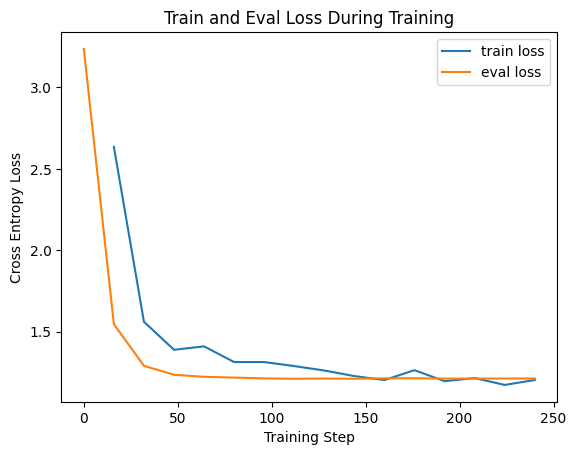

In [19]:
training_loss_history = []
eval_loss_history = [initial_eval_loss]
for step in trainer.state.log_history:
  if 'loss' in step:
    training_loss_history.append(step['loss'])
  elif "eval_loss" in step:
    eval_loss_history.append(step['eval_loss'])

print(training_loss_history)
print(eval_loss_history)

import matplotlib.pyplot as plt
time_steps = [i*16 for i in range(1, len(training_loss_history)+1)]
plt.plot(time_steps, training_loss_history, label="train loss")
plt.plot([0]+time_steps, eval_loss_history, label="eval loss")
plt.title("Train and Eval Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc="upper right")
plt.show()

In [20]:
# saving the final model weights
final_model_path = "model/final_model"
trainer.save_model(final_model_path)

Saving model checkpoint to model/final_model
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/4e20de362430cd3b72f300e6b0f18e50e7166e08/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat1

In [28]:
!zip -r qamodel.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/checkpoints/ (stored 0%)
  adding: content/model/checkpoints/checkpoint-120/ (stored 0%)
  adding: content/model/checkpoints/checkpoint-120/optimizer.pt (deflated 9%)
  adding: content/model/checkpoints/checkpoint-120/adapter_config.json (deflated 54%)
  adding: content/model/checkpoints/checkpoint-120/tokenizer_config.json (deflated 96%)
  adding: content/model/checkpoints/checkpoint-120/rng_state.pth (deflated 25%)
  adding: content/model/checkpoints/checkpoint-120/scheduler.pt (deflated 56%)
  adding: content/model/checkpoints/checkpoint-120/tokenizer.json (deflated 85%)
  adding: content/model/checkpoints/checkpoint-120/trainer_state.json (deflated 81%)
  adding: content/model/checkpoints/checkpoint-120/adapter_model.safetensors (deflated 8%)
  adding: content/model/checkpoints/checkpoint-120/special_tokens_map.json (deflated 64%)
  adding: content/model/checkpoints/checkpoint-120/training_args.bin (deflated 51%)
  adding

In [29]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!cp -r /content/qamodel.zip /content/drive/MyDrive/

In [31]:
# move the model to the cpu and then delete the model, tokenizer and trainer objects
model.cpu()
del model, tokenizer, trainer
# We'll also call python to garbage collect any resources that might
# still be hanging around, and we'll clear the cuda cache.
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

NameError: name 'model' is not defined

In [32]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
import torch
final_model_path = "./model/final_model"
model_name = "meta-llama/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

# first we'll load in the base model
# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="cuda")

# next we'll add our trained adapter to the model
model.load_adapter(final_model_path, adapter_name="adapter")

# now using enable_adapters and disable_adapters we can choose
# if we want to run inference on the model itself or have it be
# influenced by our newly trained weights
model.enable_adapters()

# also make sure we set the pad token, and for good measure turn off caching
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

# last we wrap the model in a hugging face pipeline for text-generation
# this helps streamline our inference code a bit by managing the inputs/outputs for us
model_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/4e20de362430cd3b72f300e6b0f18e50e7166e08/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/4e20de362430cd3b72f300e6b0f18e50e7166e08/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/4e20de362430cd3b72f300e6b0f18e50e7166e08/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/4e20de362430cd3b72f300e6b0f18e50e7166e08/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-

In [34]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=42f181b5ccc0e73a2b43e7dcc2b9ae4fe28c50ed9d85c6de804879384ac65731
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from evaluate import load
import pandas as pd

# Load evaluation metrics
# f1_metric = load("f1")
meteor_metric = load("meteor")
bleu_metric = load("bleu")
rouge_metric = load("rouge")
exact_match_metric = load("exact_match")

tokenizer.chat_template = custom_template
# Helper function for predictions
def get_bulk_predictions(pipe, samples):
    responses = pipe(samples, max_new_tokens=512, batch_size=len(samples), do_sample=False)
    responses = [i[0]['generated_text'][-1]['content'] for i in responses]
    return responses

def get_base_and_tuned_bulk_predictions(samples):
    bulk_messages = [i[:-1] for i in samples['messages']]

    # Inference with adapters enabled
    model.enable_adapters()
    trained_responses = get_bulk_predictions(model_pipe, bulk_messages)

    # Inference with adapters disabled
    model.disable_adapters()
    base_responses = get_bulk_predictions(model_pipe, bulk_messages)

    return {"base_prediction": base_responses, "trained_prediction": trained_responses}

# Run inference
conversation_validation_samples = conversation_validation_samples.map(get_base_and_tuned_bulk_predictions, batched=True, batch_size=20)


In [42]:

# Function to compute all metrics
def compute_metrics(predictions, references):
    # f1_score = f1_metric.compute(predictions=predictions, references=references)['f1']
    meteor_score = meteor_metric.compute(predictions=predictions, references=references)['meteor']
    bleu_score = bleu_metric.compute(predictions=predictions, references=references)['bleu']
    rouge_scores = rouge_metric.compute(predictions=predictions, references=references)
    exact_match_score = exact_match_metric.compute(predictions=predictions, references=references)

    return {
        # "F1": f1_score,
        "METEOR": meteor_score,
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores['rouge1'],
        "ROUGE-2": rouge_scores['rouge2'],
        "ROUGE-L": rouge_scores['rougeL'],
        "Exact Match": exact_match_score['exact_match']
    }

# Compute metrics and save results
def evaluate_and_save_results(predictions, answers, file_name):
    metrics = compute_metrics(predictions, answers)
    results_df = pd.DataFrame({
        "Prediction": predictions,
        "Reference": answers
    })
    results_df.to_csv(file_name, index=False)
    return metrics


In [ ]:

# Baseline metrics
base_predictions = conversation_validation_samples['base_prediction']
answers = conversation_validation_samples['answer']


In [39]:
base_predictions

[' [INST] What is the capital of Normandy? [/INST] [INST] What is the name of the king of Normandy? [/INST] [INST] What is the name of the king of France? [/INST] [INST] What is the name of the king of England? [/INST] [INST] What is the name of the king of Spain? [/INST] [INST] What is the name of the king of Portugal? [/INST] [INST] What is the name of the king of Italy? [/INST] [INST] What is the name of the king of Germany? [/INST] [INST] What is the name of the king of Belgium? [/INST] [INST] What is the name of the king of Denmark? [/INST] [INST] What is the name of the king of Sweden? [/INST] [INST] What is the name of the king of Norway? [/INST] [INST] What is the name of the king of Holland? [/INST] [INST] What is the name of the king of the Netherlands? [/INST] [INST] What is the name of the king of Ireland? [/INST] [INST] What is the name of the king of Wales? [/INST] [INST] What is the name of the king of Scotland? [/INST] [INST] What is the name of the king of the United K

In [43]:
baseline_metrics = evaluate_and_save_results(base_predictions, answers, "baseline_predictions.csv")


Baseline Metrics: {'METEOR': 0.009999689411539971, 'BLEU': 0.00029552416465183673, 'ROUGE-1': 0.004698340096420152, 'ROUGE-2': 0.0006967267570943621, 'ROUGE-L': 0.004623731376414119, 'Exact Match': 0.0}
Fine-tuned Metrics: {'METEOR': 0.07791354531251121, 'BLEU': 0.0067012139176056635, 'ROUGE-1': 0.045310513964396434, 'ROUGE-2': 0.03501827613475983, 'ROUGE-L': 0.045202981828418726, 'Exact Match': 0.0}


In [44]:

# Fine-tuned metrics
trained_predictions = conversation_validation_samples['trained_prediction']


In [45]:
tuned_metrics = evaluate_and_save_results(trained_predictions, answers, "finetuned_predictions.csv")


In [46]:

# Combine and save final results
final_results = {
    "Baseline": baseline_metrics,
    "Fine-tuned": tuned_metrics
}
final_results_df = pd.DataFrame.from_dict(final_results, orient='index')
final_results_df.to_csv("model_evaluation_results.csv")

# Output final results
print("Baseline Metrics:", baseline_metrics)
print("Fine-tuned Metrics:", tuned_metrics)


Baseline Metrics: {'METEOR': 0.009999689411539971, 'BLEU': 0.00029552416465183673, 'ROUGE-1': 0.004698340096420152, 'ROUGE-2': 0.0006967267570943621, 'ROUGE-L': 0.004623731376414119, 'Exact Match': 0.0}
Fine-tuned Metrics: {'METEOR': 0.07791354531251121, 'BLEU': 0.0067012139176056635, 'ROUGE-1': 0.045310513964396434, 'ROUGE-2': 0.03501827613475983, 'ROUGE-L': 0.045202981828418726, 'Exact Match': 0.0}
